In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [22]:
# Hyperparameters

N = 20
n = 10_000

e_values = [0.5, 1.0]
batch_size = 1
true_theta = np.array([0.0, 0.0, 0.0, 2.0])
d = len(true_theta)
lambda_ = 10 * d # Weith more initial identity matrix for hessian_bar, diverge less with lambda=100
delta = 0.2
nu_list = [0.66, 0.75]
c_nu = 1.0
tau = 2.0 # For weighted average

In [23]:
def generate_spherical_distribution(
    n: int, true_theta: np.ndarray, delta: float
) -> np.ndarray:
    """
    Generate spherical distribution data
    """
    mu = true_theta[:-1]
    r = true_theta[-1]

    # U is randomly generated on the unit sphere
    U = np.random.randn(n, mu.shape[0])
    U /= np.linalg.norm(U, axis=1, keepdims=True)

    # W is a random scaling factor to vary the radius slightly
    W = np.random.uniform(1 - delta, 1 + delta, n)

    X = mu + r * U * W[:, None]

    return X


def generate_initial_theta(true_theta: np.ndarray, e: float) -> np.ndarray:
    """
    Generate a random initial theta
    """
    initial_theta = true_theta + e * np.random.randn(true_theta.size)
    return initial_theta

In [24]:
def plot_errors(
    all_errors_avg: dict, ylabel: str, N: int
):
    """
    Plot errors for each value of e in separate subplots, each with its own y-axis scale.
    """
    num_e_values = len(all_errors_avg)
    fig, axes = plt.subplots(
        1, num_e_values, figsize=(10 * num_e_values, 6), sharey=False
    )

    if num_e_values == 1:
        axes = [axes]  # Make sure axes is iterable

    for ax, (e, errors_dict) in zip(axes, all_errors_avg.items()):
        for nu, errors in errors_dict.items():
            ax.plot(errors, label=f'WASNA nu={nu}')

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Sample size")
        ax.set_title(f"e={e}")
        ax.legend(loc="lower left")

    # Adjust layout to provide space for ylabel
    fig.subplots_adjust(left=0.1)
    average = f" Average over {N} run" + ("s" if N > 1 else "")
    fig.text(0.0, 0.5, ylabel + average, va="center", rotation="vertical")

    plt.suptitle(
        f"Spherical model, spherical distribution dataset, batch size={batch_size}"
    )
    plt.tight_layout(pad=3.0)
    plt.show()

np.set_printoptions(precision=2, suppress=True)

  0%|          | 0/800000 [00:00<?, ?it/s]

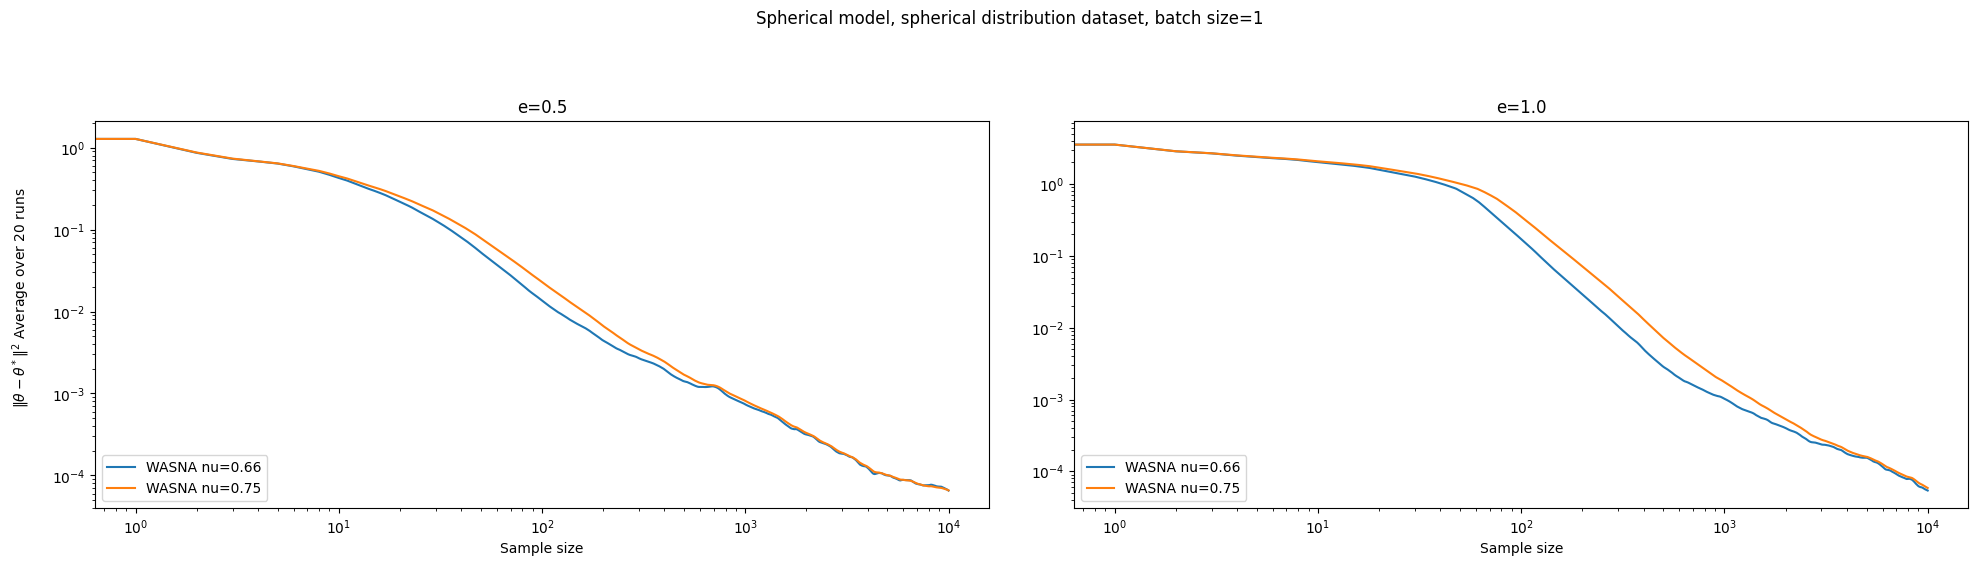

In [33]:
# Initialize the directory to store the results
all_theta_errors = {}

progress_bar = tqdm(total=len(e_values) * len(nu_list) * N * (n // batch_size))

for e in e_values:
    theta_errors_avg = {nu: 0.0 for nu in nu_list}
    for _ in range(N):
        theta_errors = {nu: [] for nu in nu_list}
        # Same dataset and initial theta for all nu
        dataset = generate_spherical_distribution(n, true_theta, delta)
        initial_theta = generate_initial_theta(true_theta, e)
        for nu in nu_list:
            theta_avg = initial_theta.copy()
            sum_weights = 0
            theta_not_avg = initial_theta.copy()
            # Wheigt more the initial identity matrix
            hessian_bar = lambda_ * np.eye(initial_theta.size)
            # Log initial error
            theta_errors[nu].append(
                np.dot(theta_avg - true_theta, theta_avg - true_theta)
            )

            # iterate over the dataset for the current nu
            for iter in range(len(dataset)):
                X = dataset[iter]
                
                # Compute the gradient in theta_not_avg
                a = theta_not_avg[:-1]
                b = theta_not_avg[-1]
                norm = np.linalg.norm(X - a)
                grad_a = a - X + b * (X - a) / norm
                grad_b = b - norm
                grad = np.append(grad_a, grad_b)

                # Compute the hessian in theta_not_avg
                a = theta_not_avg[:-1]
                b = theta_not_avg[-1]
                norm = np.linalg.norm(X - a)
                hessian = np.empty((d, d))
                hessian[:-1, :-1] = (1 - b / norm) * np.eye( d - 1) + b / norm**3 * np.outer(X - a, X - a)
                hessian[-1, :-1] = X - a / norm
                hessian[:-1, -1] = X - a / norm
                hessian[-1, -1] = 1

                # # Compute the hessian in theta_avg, cf article
                # a = theta_avg[:-1]
                # b = theta_avg[-1]
                # norm = np.linalg.norm(X - a)
                # hessian = np.empty((d, d))
                # hessian[:-1, :-1] = (1 - b / norm) * np.eye( d - 1) + b / norm**3 * np.outer(X - a, X - a)
                # hessian[-1, :-1] = X - a / norm
                # hessian[:-1, -1] = X - a / norm
                # hessian[-1, -1] = 1

                # # WASGD
                # hessian = np.eye(d)

                # if not np.all(np.linalg.eigvals(hessian) >= 0):
                #     print(hessian)
                #     raise ValueError("Hessian is not positive definite")

                # Update hessian_inv
                hessian_bar += hessian
                hessian_inv = np.linalg.inv(hessian_bar / (lambda_ + iter + 1))

                # Update theta_not_avg
                learning_rate = c_nu * (iter + 1) ** (-nu)
                theta_not_avg += -learning_rate * hessian_inv @ grad

                # Update theta_avg
                weight = math.log(iter + 2) ** tau
                sum_weights += weight
                theta_avg += (theta_not_avg - theta_avg) * weight / sum_weights

                # Log error
                theta_errors[nu].append(
                    np.dot(theta_avg - true_theta, theta_avg - true_theta)
                )

                progress_bar.update(1)

        # Average errors over N runs
        for nu, errors in theta_errors.items():
            theta_errors_avg[nu] += np.array(theta_errors[nu]) / N

    # Store the average errors for the current e
    all_theta_errors[e] = theta_errors_avg

progress_bar.close()

ylabel = ylabel = r"$\| \theta - \theta^* \|^2$"
plot_errors(all_theta_errors, ylabel, N)